In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version="v2")


In [3]:
# Get all Asstes
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]
#tradeable

In [4]:
# Create a new empty DataFrame
asset_info_df = pd.DataFrame()
asset_info_df["symbol"] = pd.Series([asset.symbol for asset in assets])
#asset_info_df.sort_values("symbol", inplace=True)

# Display the first 10 asset tickers
asset_info_df.head(10)

,symbol
0,A
1,AACH
2,AAME
3,AAOI
4,AAP
5,AAU
6,AAWW
7,AAXN
8,ABC
9,ABCB


In [5]:
# Set the ticker
ticker = input("Enter the ticker to run the Monte Carlo Simulation")

# Set timeframe to "1D"
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp("2019-03-20", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-03-20", tz="America/New_York").isoformat()

# Get 1 year"s worth of historical data for the desired stock
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.tail()

Enter the ticker to run the Monte Carlo Simulation RBC


RBC                               
                            open   high      low  close  volume
2020-03-16 00:00:00-04:00  59.01  63.96  59.0100  61.10  620330
2020-03-17 00:00:00-04:00  62.14  69.51  60.2200  68.75  714140
2020-03-18 00:00:00-04:00  64.52  66.73  55.8311  57.43  544352
2020-03-19 00:00:00-04:00  56.90  59.80  55.2200  59.12  676528
2020-03-20 00:00:00-04:00  59.70  63.27  57.4800  57.65  776882

In [6]:
# Drop Outer Table Level
df = df.droplevel(axis=1, level=0)


# Use the drop function to drop extra columns
df.drop(columns=["open", "high", "low", "volume"], inplace=True)


# Since this is daily data, we can keep only the date (remove the time) component of the data
df.index = df.index.date

df.tail()

,close
2020-03-16,61.10
2020-03-17,68.75
2020-03-18,57.43
2020-03-19,59.12
2020-03-20,57.65


In [7]:
# Use the `pct_change` function to calculate daily returns of BB
daily_returns = df.pct_change()

# Use the `mean` function to calculate the mean of daily returns for BB
avg_daily_return = daily_returns.mean()["close"]

# Use the `std` function to calculate the standard deviation of daily returns for BB
std_dev_daily_return = daily_returns.std()["close"]

In [8]:
# Set number of trading days and get last closing price of TSLA from DataFrame
num_simulations = 1000
num_trading_days = 81 
stock_last_price = df["close"][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `1000` times
for n in range(num_simulations):
    # Initialize the simulated prices list with the last closing price of TSLA
    simulated_ticker_prices = [stock_last_price]

        # Simulate the returns for 81  trading days (till 20th july 2020)
    for i in range(num_trading_days):
        # Calculate the simulated price using the last price within the list
        simulated_price = simulated_ticker_prices[-1] * (1 + np.random.normal(avg_daily_return, std_dev_daily_return))
        # Append the simulated price to the list
        simulated_ticker_prices.append(simulated_price)
    
    # Append the simulated prices of each simulation to DataFrame
    simulated_price_df[f"Simulation {n+1}"] = pd.Series(simulated_ticker_prices)

# Print head of DataFrame
simulated_price_df.head()

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0,57.650000,57.650000,57.650000,57.650000,57.650000,57.650000,57.650000,57.650000,57.650000,57.650000,...,57.650000,57.650000,57.650000,57.650000,57.650000,57.650000,57.650000,57.650000,57.650000,57.650000
1,59.432449,59.697260,57.476498,59.776577,56.884222,56.853066,57.817902,56.388342,57.251738,59.808671,...,58.475323,57.158608,56.017271,59.099903,57.102652,57.385777,60.445220,57.391207,58.052024,58.921270
2,58.969457,59.600916,59.845214,57.859608,55.927434,56.990142,58.319552,58.658513,57.784553,63.230504,...,59.047039,60.019610,55.934093,58.161033,57.440684,57.449750,60.485485,57.740115,57.515010,56.269888
3,60.763468,58.920859,58.690672,57.467620,55.033686,56.681166,59.122406,58.077216,57.323588,61.778895,...,58.653629,59.311485,56.731359,55.373446,58.740910,55.525621,61.507612,55.027989,55.757606,55.538897
4,58.725226,62.029218,59.072630,57.193933,54.470373,58.242437,59.176748,57.049955,55.608402,62.661101,...,59.545963,58.110115,54.479001,56.628534,56.681718,55.597664,59.644110,54.228115,54.032112,56.595759


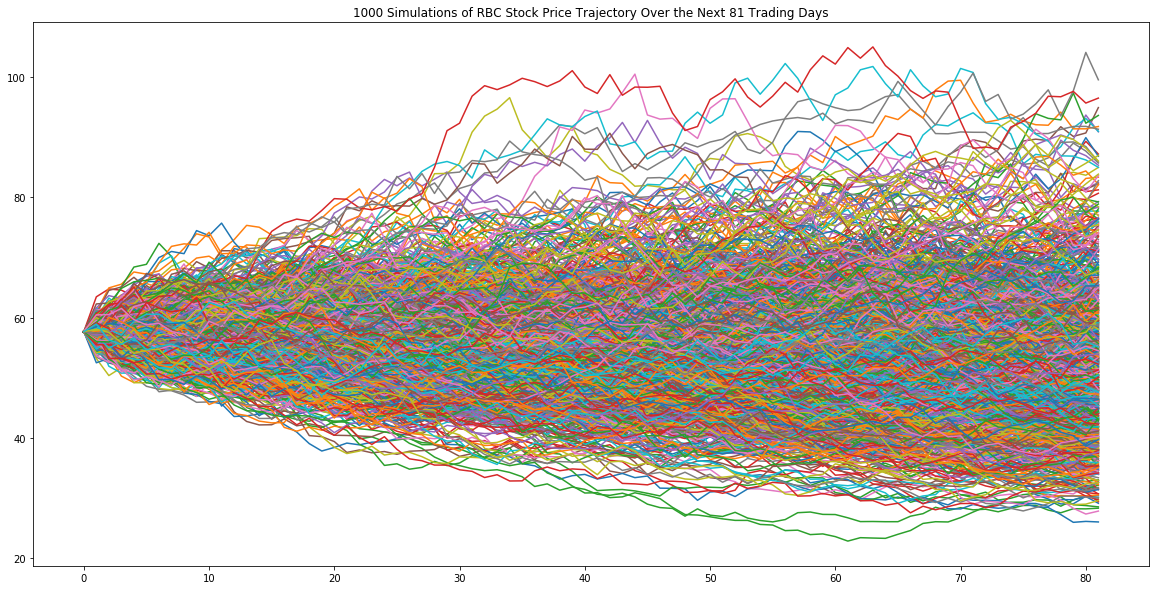

In [9]:
# Use the `plot` function to plot the trajectory of given stock based on a 81 trading day simulation
plot_title = f"{n+1} Simulations of {ticker} Stock Price Trajectory Over the Next 81 Trading Days"
simulated_price_df.plot(legend=None, title=plot_title, figsize =[20,10])

In [10]:
# Select the last row for projecting stock prices (prices of each simulation on the last simulated trading day)
simulated_ending_prices = simulated_price_df.iloc[-1, :]
simulated_ending_prices.head()

Simulation 1    61.232374
Simulation 2    57.599790
Simulation 3    64.602404
Simulation 4    41.311082
Simulation 5    79.286909
Name: 81, dtype: float64

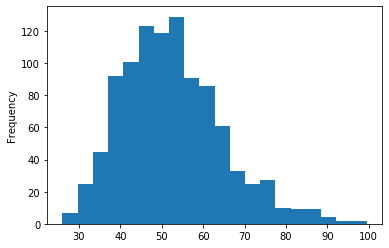

In [11]:
# Use the `plot` function to plot a frequency distribution of simulated ending prices
simulated_ending_prices.plot(kind='hist', bins=20)

In [12]:
# Use the `value_counts` function to create the frequency distribution and 
# sort the data into 20 bins. Divide the value counts of each bin by the total
# number of prices to return the probability of each range
simulated_ending_prices.value_counts(bins=20) / len(simulated_ending_prices)

(51.736, 55.413]                0.129
(44.382, 48.059]                0.123
(48.059, 51.736]                0.119
(40.704, 44.382]                0.101
(37.027, 40.704]                0.092
(55.413, 59.091]                0.091
(59.091, 62.768]                0.086
(62.768, 66.445]                0.061
(33.35, 37.027]                 0.045
(66.445, 70.123]                0.033
(73.8, 77.477]                  0.027
(29.672, 33.35]                 0.025
(70.123, 73.8]                  0.025
(77.477, 81.155]                0.010
(84.832, 88.509]                0.009
(81.155, 84.832]                0.009
(25.919999999999998, 29.672]    0.007
(88.509, 92.186]                0.004
(92.186, 95.864]                0.002
(95.864, 99.541]                0.002
Name: 81, dtype: float64

In [13]:
# Use the `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = simulated_ending_prices.quantile(q=[0.025, 0.975])
confidence_interval

0.025    32.588111
0.975    81.254738
Name: 81, dtype: float64

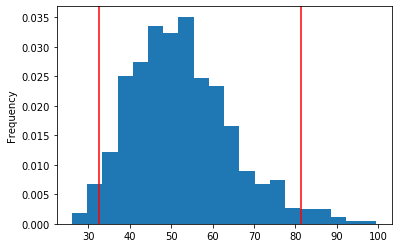

In [14]:
# Use the `plot` function to create a probability distribution histogram of simulated ending prices
# with markings for a 95% confidence interval
plt.figure();
simulated_ending_prices.plot(kind='hist', density=True, bins=20)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

In [15]:
# Set timeframe to "1D"
timeframe = "1D"

# Set the dates for the price of the desired stock for 20 July 2020
start_date = pd.Timestamp("2020-07-19", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-07-20", tz="America/New_York").isoformat()

# Get actual stock price for the desired stock on 20th July 2020
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df

RBC                             
                           open   high    low  close  volume
2020-07-20 00:00:00-04:00  91.5  92.24  90.15  90.97  137208